Marketplace1: 111166, Marketplace2: 21178.0, Marketplace3: 29037.0


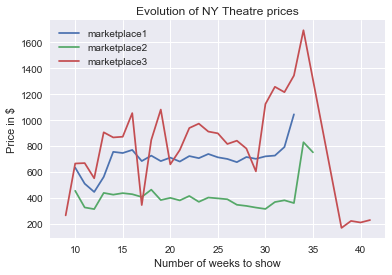

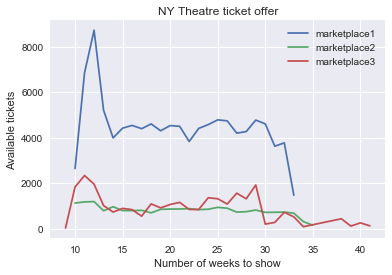

In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from matplotlib import rc
import itertools

data = {}

data['marketplace1'] = pd.read_json('data/march4/marketplace1.json')
data['marketplace1']['title'] = data['marketplace1']['title'].str.replace(r"\(.*\)","")
data['marketplace1'] = data['marketplace1'][~data['marketplace1']['title'].isin(['Black Angels Over Tuskegee', 'Los Angeles Angels of Anaheim vs. New York Yankees','New York Yankees vs. Los Angeles Angels of Anaheim' ])].reset_index(drop=True)
data['marketplace1']['date'] = pd.to_datetime(data['marketplace1']['date'], format = '%Y, %m, %d, %H, %M', errors = 'coerce')
data['marketplace1']['date'] += pd.Timedelta('30 d')
data['marketplace1']['weightedprice'] = data['marketplace1']['price'] * data['marketplace1']['available'].fillna(1)

data['marketplace2'] = pd.read_json('data/march4/marketplace2.json')
data['marketplace2'] = data['marketplace2'][~data['marketplace2']['title'].isin(['New York Yankees at Los Angeles Angels', 'Los Angeles Angels at New York Yankees'])].reset_index(drop=True)
data['marketplace2'].rename(columns={'number':'available', 'section':'category'}, inplace=True)
data['marketplace2']['date'] = pd.to_datetime(data['marketplace2']['date'].astype(str).str.replace(' at ',' 2018 0').str.replace('pm','PM').str.replace(':00',' '), format = '%a %b %d %Y %I %p', errors = 'coerce')
data['marketplace2']['price'] = data['marketplace2']['price'].str.replace('$', '')
data['marketplace2']['price'] = (data['marketplace2']['price'].replace(r'[k]+$', '', regex=True).astype(float) * data['marketplace2']['price'].str.extract(r'[\d\.]+([k]+)', expand=False).fillna(1).replace(['k'], [10**3]).astype(int))
data['marketplace2']['available'] = data['marketplace2']['available'].str.replace('e-tickets', '').str.replace('e-ticket', '').str.replace('tickets', '').str.replace('ticket', '').str.replace(' ', '').str.replace('-','').str[-1].astype(float)
data['marketplace2']['weightedprice'] = data['marketplace2']['price'] * data['marketplace2']['available'].fillna(1)


data['marketplace3'] = pd.read_json('data/march4/marketplace3.json')
data['marketplace3'].rename(columns={'number':'available', 'section':'category'}, inplace=True)
data['marketplace3']['date'] = pd.to_datetime(data['marketplace3']['date'], format = '%A, %d %B %Y %H:%M', errors = 'coerce')
data['marketplace3']['price'] = data['marketplace3']['price'].str.replace(',', '').astype(float)
data['marketplace3']['weightedprice'] = data['marketplace3']['price'] * data['marketplace3']['available'].fillna(1)
data['marketplace3']['category'] = data['marketplace3']['category'].str.strip('Section: ')

data['feb'] = pd.read_json('data/feb25/marketplace1.json')
data['feb']['date'] = pd.to_datetime(data['feb']['date'], format = '%Y, %m, %d, %H, %M', errors = 'coerce')
data['feb']['weightedprice'] = data['feb']['price'] * data['feb']['available']


def week_mean(x):
    return x.groupby(x['date'].dt.week)['weightedprice'].sum()/x.groupby(x['date'].dt.week)['available'].sum()

def week_available(x):
    return x.groupby(x['date'].dt.week)['available'].sum()
    
def number(x):
    return x['available'].sum()

def correl(x,i):
    n = week_available(x).size
    shifted_week_available = week_available(x).copy().reset_index(drop=True)
    for j in range(n-i): 
        shifted_week_available[j] = week_available(x).reset_index(drop=True)[i+j]
    shiftedcov_df = pd.concat([week_mean(x).reset_index(drop=True), shifted_week_available], axis=1)
    shiftedcov_mat = shiftedcov_df.cov()
    correl = shiftedcov_mat[0].iloc[1]/(np.sqrt(shiftedcov_mat[0].iloc[0]) * np.sqrt(shiftedcov_mat['available'].iloc[1]))
    return correl

def platcorrel(x,y):
    n = min(x.shape[0],y.shape[0])
    cov_df = pd.concat([x.reset_index(drop=True)[:n], y.reset_index(drop=True)[:n]], axis=1)
    cov_mat = cov_df.cov()
    availcorr = cov_mat.iloc[0,1]/(np.sqrt(cov_mat.iloc[0,0]) * np.sqrt(cov_mat.iloc[1,1]))
    return availcorr
    
def hist(x):
    hist = []
    n = x.shape[0]
    for i in range(n):
        for j in range(int((x['available'].fillna(1)).loc[i])):
            hist.append(x['price'].iloc[i])
    return hist
    
def weeklyplot(x,y,z, t, ylab):
    ax = x.plot(title = t, label = 'marketplace1')
    y.plot(label = 'marketplace2')
    z.plot(label = 'marketplace3')
    ax.set_xlabel('Number of weeks to show')
    ax.set_ylabel(ylab)
    plt.legend()
    plt.show()

def histPlot(x, y,z, t):
    plt.hist(x, bins = 100, alpha=0.8, label='marketplace1')
    plt.hist(y, bins = 100, alpha=0.7, label='marketplace2')
    plt.hist(z, bins = 100, alpha=0.7, label='marketplace3')
    plt.xlabel('Price in $')
    plt.ylabel('Number of tickets')
    plt.title(t)
    plt.legend()
    plt.show()
    


def analytics(x, y,z, tp1, tp2, th):
    print('Marketplace1: {}, Marketplace2: {}, Marketplace3: {}'.format(number(x), number(y), number(z)))
    weeklyplot(week_mean(x), week_mean(y)[10:], week_mean(z), tp1, 'Price in $')
    weeklyplot(week_available(x), week_available(y)[10:],week_available(z), tp2, 'Available tickets' )
#    histPlot(hist(x), hist(y), hist(z), th)
    
analytics(data['marketplace1'],data['marketplace2'], data['marketplace3'], 'Evolution of NY Theatre prices', 'NY Theatre ticket offer', 'NY Theatre price spread')



Marketplace1: 38039, Marketplace2: 6932.0, Marketplace3: 5352.0


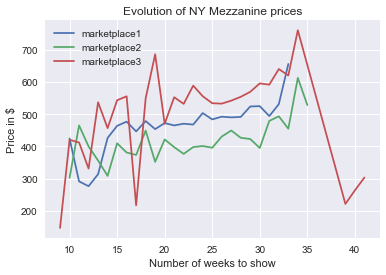

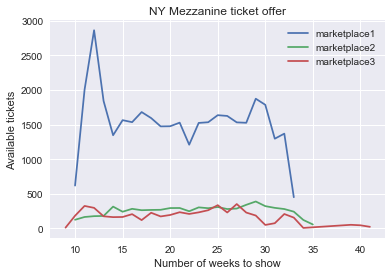

In [4]:
def mezz(x):
    return x[x['category'].str.lower().str.contains('mezz|box') | x['category'].isin(['Zone C','Zone D','Zone E','Zone F'])]

market_mezz = {}
for k,m in data.items():
    market_mezz[k] = mezz(m).reset_index(drop=True)
    
analytics(market_mezz['marketplace1'],market_mezz['marketplace2'], market_mezz['marketplace3'], 'Evolution of NY Mezzanine prices', 'NY Mezzanine ticket offer', 'NY Mezzanine price spread')


Marketplace1: 58122, Marketplace2: 12934.0, Marketplace3: 23211.0


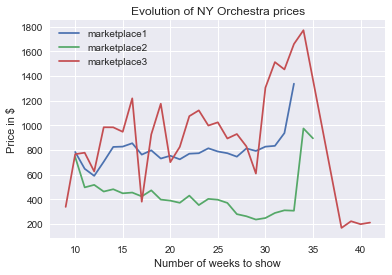

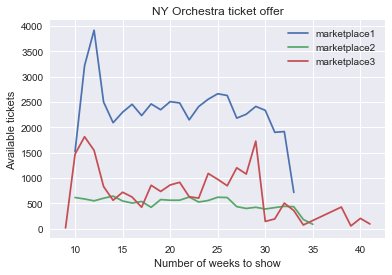

In [5]:
def orch(x):
    return x[x['category'].str.lower().str.contains('orch')| x['category'].isin(['Zone A','Zone B','Zone Premium'])]

market_orch = {}
for k,m in data.items():
    market_orch[k] = orch(m).reset_index(drop=True)
    
analytics(market_orch['marketplace1'], market_orch['marketplace2'], market_orch['marketplace3'], 'Evolution of NY Orchestra prices', 'NY Orchestra ticket offer', 'NY Orchestra price spread')


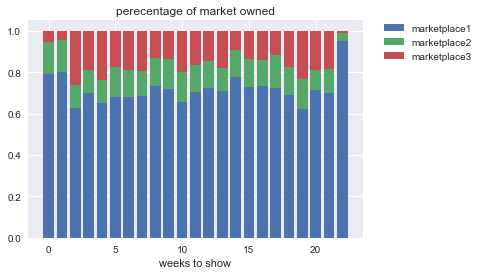

In [6]:
avail_df = pd.concat([week_available(data['marketplace1']).reset_index(drop=True)[:23], week_available(data['marketplace2']).reset_index(drop=True)[:23], week_available(data['marketplace3']).reset_index(drop=True)[:23]], axis=1)
avail_df.columns =['marketplace1', 'marketplace2', 'marketplace3']
avail_df['total'] = avail_df['marketplace1'] + avail_df['marketplace2'] + avail_df['marketplace3']
r = []
for a in reversed(list(range(23))):
    r.append(a)
plt.bar(r,avail_df['marketplace1']/avail_df['total'], label = 'marketplace1')
plt.bar(r,avail_df['marketplace2']/avail_df['total'], bottom=avail_df['marketplace1']/avail_df['total'], label = 'marketplace2')
plt.bar(r,avail_df['marketplace3']/avail_df['total'], bottom=(avail_df['marketplace1'] + avail_df['marketplace2'])/avail_df['total'], label = 'marketplace3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("weeks to show")
plt.title("perecentage of market owned")
plt.show()

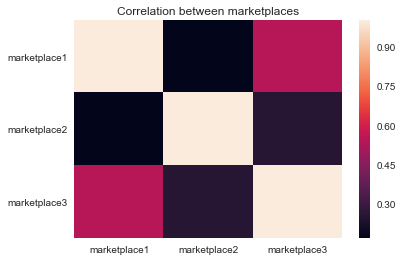

In [8]:
plat = [data['marketplace1'], data['marketplace2'], data['marketplace3']]
correlmat = pd.DataFrame({'marketplace1': [0 ]*3, 'marketplace2' :[0 ]*3,'marketplace3' :[0 ]*3})
correlmat.index = ['marketplace1', 'marketplace2', 'marketplace3']
for i in range(3):
    for j in range(3):
        correlmat.iloc[i,j] = platcorrel(week_mean(plat[i]),week_mean(plat[j]))

ax = plt.axes()
sns.heatmap(correlmat, ax = ax)
ax.set_title('Correlation between marketplaces')
plt.yticks(rotation=0) 
plt.show()

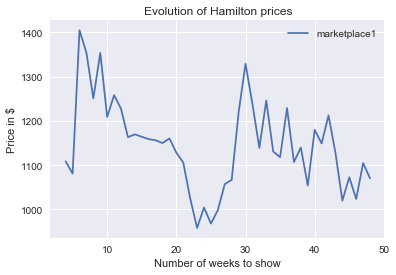

In [13]:
ax = week_mean(data['feb']).plot(title = 'Evolution of Hamilton prices', label = 'marketplace1')
ax.set_xlabel('Number of weeks to show')
ax.set_ylabel('Price in $')
plt.legend()
plt.show()


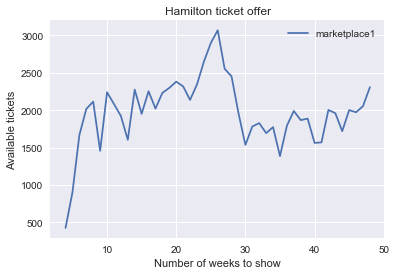

Correlation between supply and price 0 weeks before: -0.36139217042171157
Correlation between supply and price 1 weeks before: -0.3634838041434374
Correlation between supply and price 2 weeks before: -0.4705930075751193
Correlation between supply and price 3 weeks before: -0.41878666955187077


In [18]:
ax = week_available(data['feb']).plot(title = 'Hamilton ticket offer', label = 'marketplace1')
ax.set_xlabel('Number of weeks to show')
ax.set_ylabel('Available tickets')
plt.legend()
plt.show()
for i in range(4):
        print('Correlation between supply and price {} weeks before: {}'.format(i,correl(data['feb'],i)))

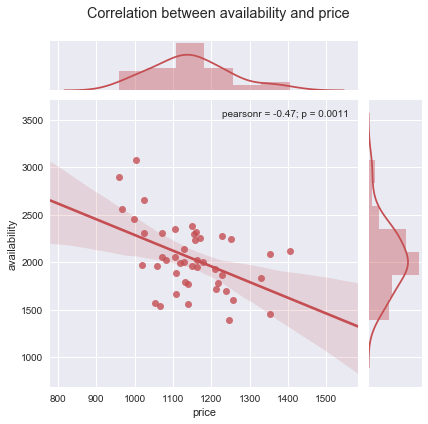

In [16]:
n = week_available(data['feb']).size
shifted_week_available = week_available(data['feb']).copy().reset_index(drop=True)
for j in range(n-2): 
    shifted_week_available[j] = week_available(data['feb']).reset_index(drop=True)[j+2]

shiftedcov_df = pd.concat([week_mean(data['feb']).reset_index(drop=True), shifted_week_available], axis=1)
shiftedcov_df.columns = ['price', 'availability']
jp = sns.jointplot(x='price', y='availability', data = shiftedcov_df, color='r', kind="reg")
fig = jp.fig
fig.subplots_adjust(top=0.9)
fig.suptitle('Correlation between availability and price')
plt.show()